### 피부암데이터셋(HAM10000)를 활용한 분류


<br>

Data From : https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

HAM10000데이터셋을 활용한 피부암 조기 진단을 위한 분류기입니다.

데이터는 28x28 사이즈를 가진 10000여장의 피부암(7종)사진으로 이루어져있습니다.

다음과 같은 단계로 진행되었습니다.

<br>

**1. 메타데이터 분석**

<br>

**2. 이미지 데이터 분석**
    
    2.1 오버샘플링 및 데이터 추출
    
    2.2 이미지 전처리

**3. 모델링**
    
    3.1 Resnet50(pretrained model weights from imagnet)
    
    3.2 모델 성능 평가

**4. CAM**
    
    4.1 CAM 모델 선언
    
    4.2 시각화

        

##  1.메타데이터 분석

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Text(0.5, 1.0, 'Frequency Distribution of Classes')

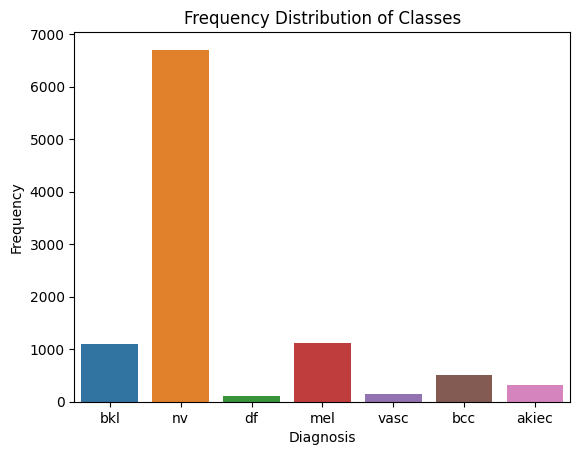

In [ ]:
sns.countplot(x = 'dx', data = data)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

In [ ]:
data.info()

Text(0.5, 1.0, 'Frequency Distribution of Gender')

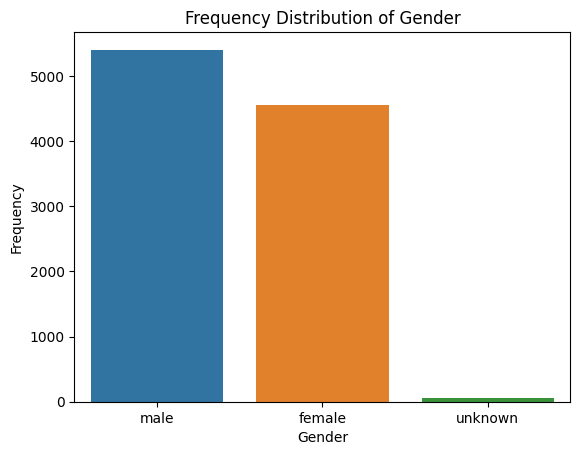

In [ ]:
sns.countplot(x = 'sex', data = data)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Gender')

Text(0.5, 1.0, 'Frequency Distribution of Ages')

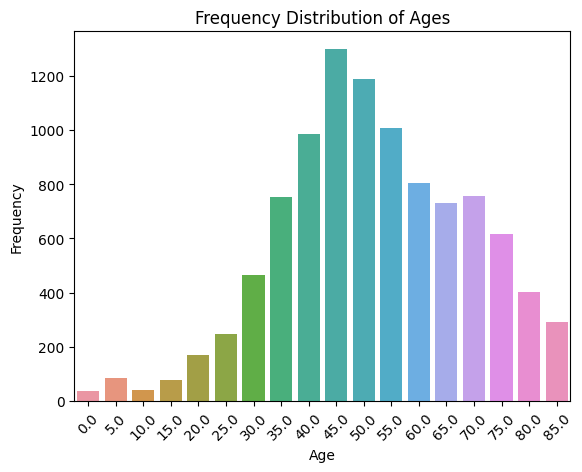

In [ ]:
sns.countplot(x = 'age', data = data)
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Ages')

Text(0.5, 1.0, 'Frequency Distribution of Location')

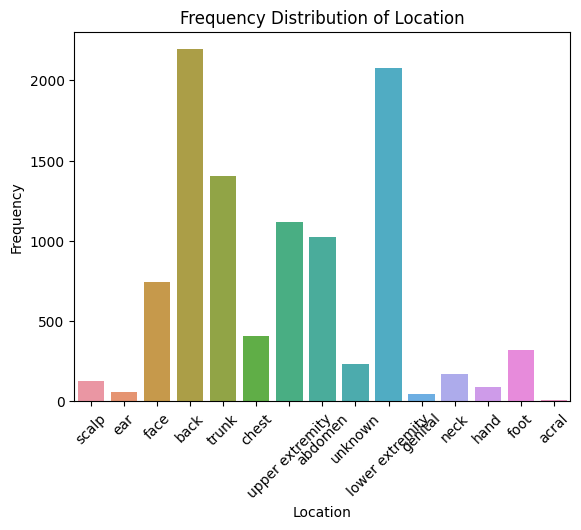

In [ ]:
sns.countplot(x = 'localization', data = data)
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Location')

## 2.이미지 데이터 분석

### 2.1 이미지 불러오기 

In [ ]:
data_img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
print('shape: ',data_img.shape)
print('column names: ',data_img.columns)

shape:  (10015, 2353)
column names:  Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)


In [ ]:
data.shape

### 2.2 OverSampling

In [ ]:
data_img.shape

Shape of X : (46935, 28, 28, 3)


Text(0.5, 1.0, 'Frequency Distribution of Classes')

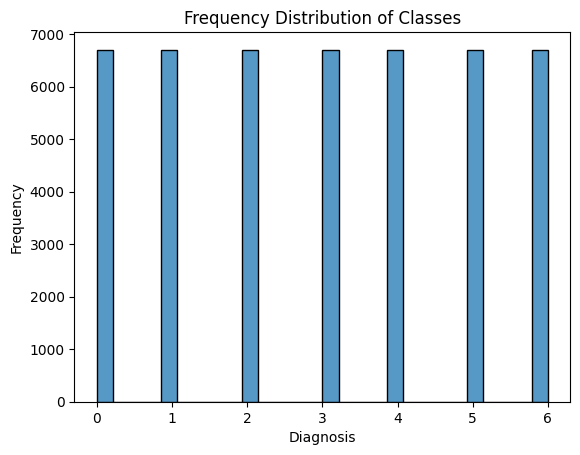

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()

X_over = data_img.drop(columns = ['label'])
y_over = data_img['label']

X_over,y_over  = oversample.fit_resample(X_over,y_over)
X_over = np.array(X_over).reshape(-1,28,28,3)
print('Shape of X :',X_over.shape)

sns.histplot(y_over)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

### 2.3 데이터 추출

> 오버샘플링 한 후, 빠른 결과를 보기위해 stratify하게 15프로만 추출해서 사용.

In [ ]:
from sklearn.model_selection import train_test_split
x_over,x_test,Y_over,Y_test=train_test_split(X_over,y_over,test_size=0.85,stratify=y_over,random_state=11)

<AxesSubplot: xlabel='label', ylabel='Count'>

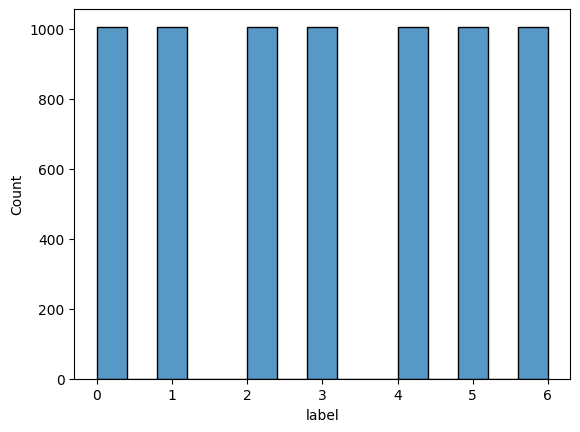

In [ ]:
sns.histplot(Y_over)

### 2.4 이미지 전처리

In [ ]:
IMAGE_SIZE = 128

from tensorflow.keras.utils import to_categorical
import scipy as sp

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
Y_over = to_categorical(Y_over)
x_over = np.array(x_over).reshape(-1,28,28,3)
t = np.zeros([len(x_over), IMAGE_SIZE, IMAGE_SIZE, 3],dtype=np.float32)
for i in range(len(x_over)):
    t[i] = sp.ndimage.zoom(x_over[i],(IMAGE_SIZE/28,IMAGE_SIZE/28,1))
x_over = np.array(t).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
x_over = resnet_preprocess(x_over)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_over,Y_over, test_size=0.2, random_state=2023)
X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train, test_size=0.2, random_state=2023)

## 3.모델링

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D , MaxPooling2D , BatchNormalization, Activation, Flatten ,  GlobalAveragePooling2D, Dense ,  Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

### 3.1 모델선언
> Cam용으로는 AVG pool과 Output이 바로연결되도록 구성한다.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

BATCH_SIZE = 30

def model_resnet(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7):
    input_tensor = Input(shape=in_shape)
    
    base_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    #x = Dense(128, activation='relu', name='fc1')(x)
    output = Dense(n_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

**3.1.1 ImageDataGenerator**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tr_generator = ImageDataGenerator(
   
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True,
    
)
va_generator = ImageDataGenerator(
 
)


flow_tr_gen = tr_generator.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = va_generator.flow(X_va, y_va, batch_size=BATCH_SIZE, shuffle=False)

> **resnet_preprocess에서 정규화까지 진행해주기 때문에, generating에서 정규화를 쓰지 않았습니다.**

In [ ]:
model = model_resnet(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

### 3.2 모델 학습

In [ ]:

history = model.fit(flow_tr_gen,
                    steps_per_epoch=int(np.ceil(X_tr.shape[0]/BATCH_SIZE)),
                    validation_data=flow_val_gen, 
                    validation_steps=int(np.ceil(X_va.shape[0]/BATCH_SIZE)),
                    epochs = 10,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/10
151/151 [==============================] - 64s 172ms/step - loss: 1.0233 - accuracy: 0.6331 - val_loss: 1.0652 - val_accuracy: 0.6362 - lr: 1.0000e-04
Epoch 2/10
151/151 [==============================] - 24s 161ms/step - loss: 0.5813 - accuracy: 0.7909 - val_loss: 0.5790 - val_accuracy: 0.8154 - lr: 1.0000e-04
Epoch 3/10
151/151 [==============================] - 25s 168ms/step - loss: 0.4209 - accuracy: 0.8499 - val_loss: 0.5340 - val_accuracy: 0.8092 - lr: 1.0000e-04
Epoch 4/10
151/151 [==============================] - 24s 159ms/step - loss: 0.3522 - accuracy: 0.8761 - val_loss: 0.4632 - val_accuracy: 0.8412 - lr: 1.0000e-04
Epoch 5/10
151/151 [==============================] - 25s 167ms/step - loss: 0.2424 - accuracy: 0.9148 - val_loss: 0.6497 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 6/10
151/151 [==============================] - 24s 157ms/step - loss: 0.2365 - accuracy: 0.9163 - val_loss: 0.4460 - val_accuracy: 0.8376 - lr: 1.0000e-04
Epoch 7/10
151/151 [========

### 3.3 모델평가

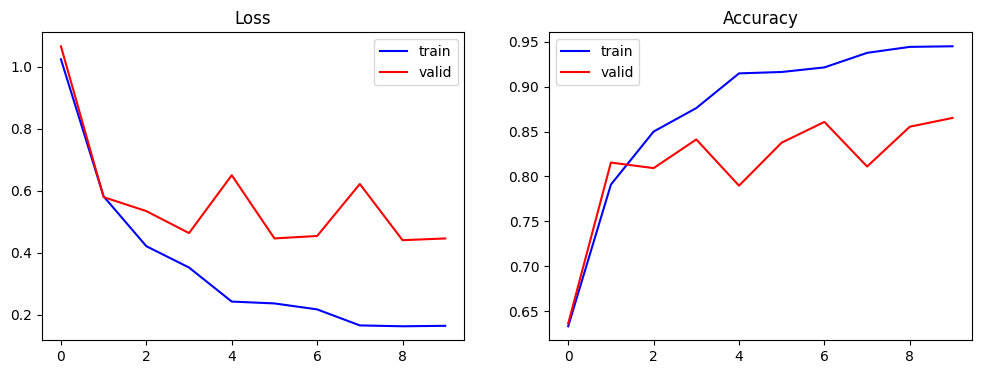

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'],c='blue')
plt.plot(history.history['val_loss'],c='red')
plt.title('Loss')
plt.legend(['train','valid'],loc='best')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='red')
plt.title('Accuracy')
plt.legend(['train','valid'],loc='best')

plt.show()

> **Train Accuracy : 0.94 Valid Accuracy : 0.86 Test Accuracy : 0.85**

kaggle notebook 환경의 메모리 제한이 13GB이기때문에, 데이터 양을 줄이고, epochs도 많이 줄였습니다. 이모델은 더 개선될 여지가 있습니다.

### 3.4 테스트 셋 평가

In [ ]:

model.evaluate(X_test,y_test)
pred = model.predict(X_test)

44/44 [==============================] - 2s 33ms/step


In [ ]:
y_prd=np.argmax(pred,axis=1)
y_prd_label=np.argmax(y_test,axis=1)

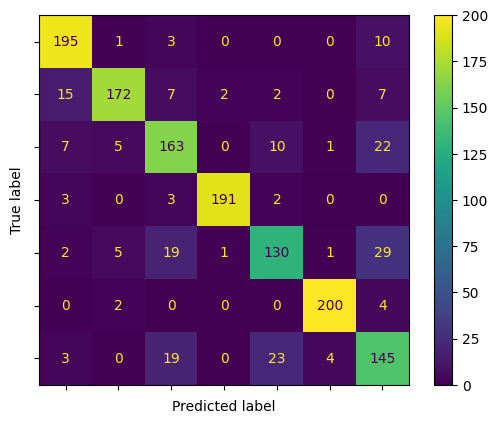

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

cm=confusion_matrix(y_prd_label,y_prd)

ConfusionMatrixDisplay(cm,display_labels=[]).plot()

## 4.CAM
> 모델 선언

In [ ]:
#the following code is referred by https://www.kaggle.com/code/ggsri123/class-activation-maps
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
def show_cam(image_value, features, results):
  
  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = np.argmax(results)

  # there is only one unit in the output so we get the weights connected to it
  gap_weights = model.layers[-1].get_weights()[0]
  class_activation_weights = gap_weights[:,prediction]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (128/4, 128/4, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


#Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed. - tf.squeeze

In [ ]:
img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
img = img.drop(columns = ['label'])
test_img = np.array(img.loc[0])
test_img = test_img.reshape(28,28,3)
test_img = sp.ndimage.zoom(test_img,(IMAGE_SIZE/28,IMAGE_SIZE/28,1))
test_img = test_img.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
test_img_proc= resnet_preprocess(test_img)

1/1 [==============================] - 1s 988ms/step


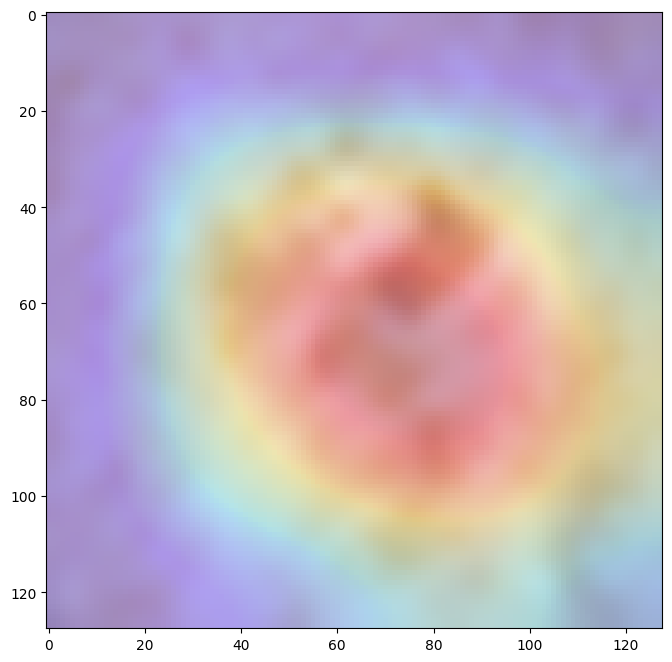

In [ ]:
#cam_input =  np.expand_dims(test_img_proc, axis=0)
features,results = cam_model.predict(test_img_proc)

show_cam(test_img, features, results)
